In [ ]:
import datetime as dt
from pathlib import Path
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt
plt.close('all')
import yfinance as yf
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [ ]:
sq_1hr = yf.download(tickers='SQ', start='2019-09-01', end = '2021-08-10', interval='1h')
sq_1hr.drop(columns = ['Open','High','Low','Adj Close','Volume'], inplace = True)
sq_1hr.reset_index(inplace=True)
sq_1hr.rename(columns = {'index':'Datetime'}, inplace = True)
sq_1hr.set_index(pd.to_datetime(sq_1hr['Datetime'],infer_datetime_format=True),inplace=True)
sq_1hr.head()

[*********************100%***********************]  1 of 1 completed


,Datetime,Close
Datetime,,
2019-09-03 09:30:00-04:00,2019-09-03 09:30:00-04:00,62.959999
2019-09-03 10:30:00-04:00,2019-09-03 10:30:00-04:00,62.320000
2019-09-03 11:30:00-04:00,2019-09-03 11:30:00-04:00,62.000000
2019-09-03 12:30:00-04:00,2019-09-03 12:30:00-04:00,61.774899
2019-09-03 13:30:00-04:00,2019-09-03 13:30:00-04:00,61.360001


In [ ]:
sq_diff = sq_1hr['Close'].diff()
up = sq_diff.clip(lower=0)
down = -1*sq_diff.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
rs

Datetime
2019-09-03 09:30:00-04:00         NaN
2019-09-03 10:30:00-04:00    0.000000
2019-09-03 11:30:00-04:00    0.000000
2019-09-03 12:30:00-04:00    0.000000
2019-09-03 13:30:00-04:00    0.000000
                               ...   
2021-08-03 15:30:00-04:00    1.282792
2021-08-04 09:30:00-04:00    0.966207
2021-08-04 10:30:00-04:00    1.060899
2021-08-04 11:30:00-04:00    1.047992
2021-08-04 12:30:00-04:00    1.106164
Name: Close, Length: 3360, dtype: float64

In [ ]:
sq_1hr['RSI'] = 100 - (100/(1 + rs))
sq_1hr['RSI'] 

Datetime
2019-09-03 09:30:00-04:00          NaN
2019-09-03 10:30:00-04:00     0.000000
2019-09-03 11:30:00-04:00     0.000000
2019-09-03 12:30:00-04:00     0.000000
2019-09-03 13:30:00-04:00     0.000000
                               ...    
2021-08-03 15:30:00-04:00    56.193989
2021-08-04 09:30:00-04:00    49.140662
2021-08-04 10:30:00-04:00    51.477497
2021-08-04 11:30:00-04:00    51.171695
2021-08-04 12:30:00-04:00    52.520323
Name: RSI, Length: 3360, dtype: float64

In [ ]:

# sq_1hr['RSI’]
sq_1hr_rsi= sq_1hr.iloc[: , 1:]
sq_1hr_rsi

,Close,RSI
Datetime,,
2019-09-03 09:30:00-04:00,62.959999,NaN
2019-09-03 10:30:00-04:00,62.320000,0.000000
2019-09-03 11:30:00-04:00,62.000000,0.000000
2019-09-03 12:30:00-04:00,61.774899,0.000000
2019-09-03 13:30:00-04:00,61.360001,0.000000
...,...,...
2021-08-03 15:30:00-04:00,269.399994,56.193989
2021-08-04 09:30:00-04:00,263.589996,49.140662
2021-08-04 10:30:00-04:00,265.660004,51.477497


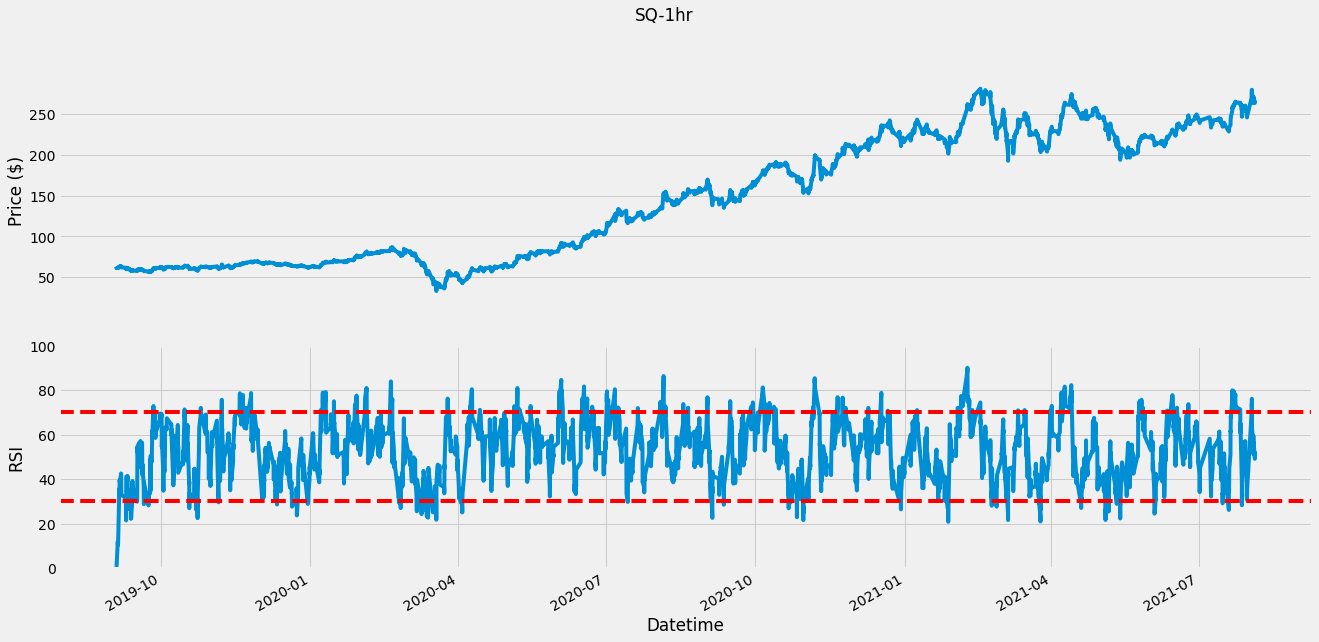

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.get_xaxis().set_visible(False)
fig.suptitle('SQ-1hr')
sq_1hr_rsi['Close'].plot(ax=ax1)

ax1.set_ylabel('Price ($)')
sq_1hr_rsi['RSI'].plot(ax=ax2)
ax2.set_ylim(0,100)
ax2.axhline(30, color= 'r', linestyle= '--')
ax2.axhline(70, color= 'r', linestyle= '--')
ax2.set_ylabel('RSI')
plt.show()

In [ ]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(sq_1hr_rsi['Close'], sq_1hr_rsi['RSI'])

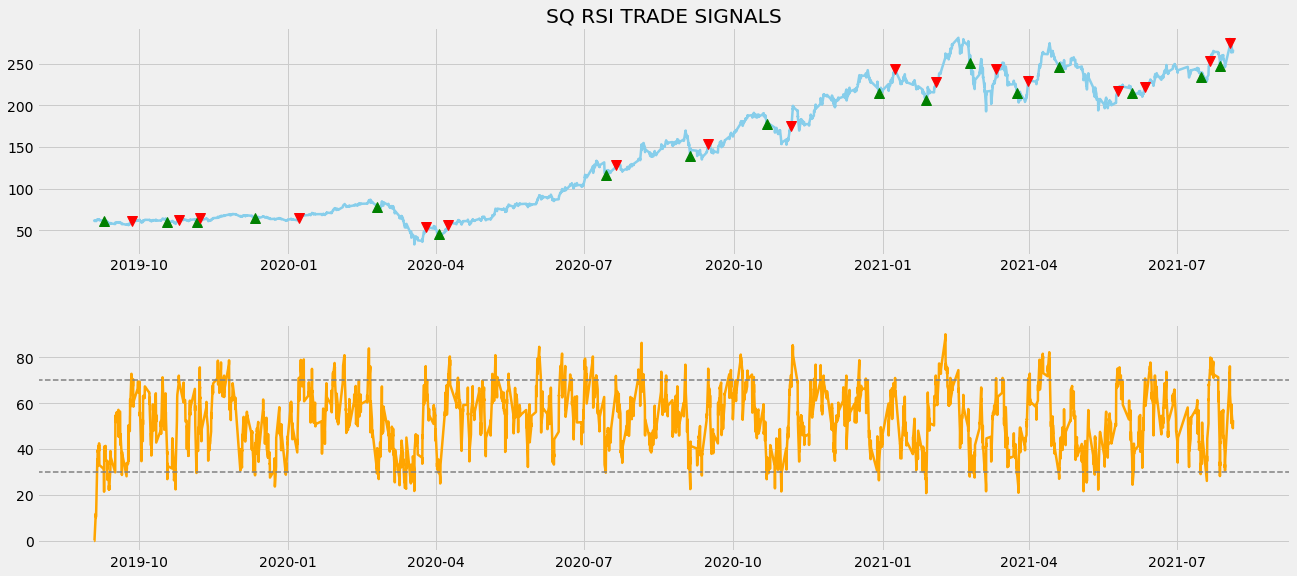

In [ ]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(sq_1hr_rsi['Close'], linewidth = 2.5, color = 'skyblue', label = 'SQ')
ax1.plot(sq_1hr_rsi.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(sq_1hr_rsi.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('SQ RSI TRADE SIGNALS')
ax2.plot(sq_1hr['RSI'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [ ]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(sq_1hr_rsi['Close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = sq_1hr_rsi['RSI']
close_price = sq_1hr_rsi['Close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(sq_1hr_rsi.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(sq_1hr_rsi.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,RSI,rsi_signal,rsi_position
Datetime,,,,
2019-09-03 09:30:00-04:00,62.959999,NaN,0,1
2019-09-03 10:30:00-04:00,62.320000,0.000000,0,1
2019-09-03 11:30:00-04:00,62.000000,0.000000,0,1
2019-09-03 12:30:00-04:00,61.774899,0.000000,0,1
2019-09-03 13:30:00-04:00,61.360001,0.000000,0,1
...,...,...,...,...
2021-08-03 15:30:00-04:00,269.399994,56.193989,0,0
2021-08-04 09:30:00-04:00,263.589996,49.140662,0,0
2021-08-04 10:30:00-04:00,265.660004,51.477497,0,0


In [ ]:
sq_1hr_rsi_ret = pd.DataFrame(np.diff(sq_1hr_rsi['Close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(sq_1hr_rsi_ret)):
    returns = sq_1hr_rsi_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/sq_1hr_rsi['Close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in SQ : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))


Profit gained from the RSI strategy by investing $100k in SQ : 36850.31
Profit percentage of the RSI strategy : 36%


In [ ]:
strategy.to_csv('SQ 1H RSI TRADE STRATEGY.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d12c285c-6789-4c45-9ad7-1be9b4d60622' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>